In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torchmetrics import AUROC, Accuracy, ROC

# Reading Data

In [125]:
def read_reports(report_path, num_epochs, mode):
    
    df = None 

    for epoch in range(num_epochs):
        report_name = f"{mode}_{epoch}.csv"
        df_epoch = pd.read_csv(os.path.join(report_path, report_name))
        
        if df is None:
            df = df_epoch
        else:
            df = pd.concat([df, df_epoch])
            
    df.drop(columns=["Unnamed: 0"], inplace=True)
            
    return df

# Training Data

In [126]:
vgg_type = "vgg19"

training_report_path = f"../reports/reports_{vgg_type}_none"

num_epochs = 50

train = read_reports(training_report_path, num_epochs, "train")

val = read_reports(training_report_path, num_epochs, "val")


## Loss Function

In [127]:
def plot_epoch(
    df1,
    df2,
    df1_label,
    df2_label,
    ylabel,
    ylim,
    yticks,
    xticks,
    title,
    save_path,
    figsize=(15,12),
    legend=True,
    num_epochs=100,
    convergence_mode="min",
    convergence_text=dict()
    ):
    min_1 = df1.min().item()
    max_1 = df1.max().item()

    min_2 = df2.min().item()
    max_2 = df2.max().item()

    min_val = min(min_1, min_2)
    max_val = max(max_1, max_2)

    ax = plt.gca()

    df1.rename(columns={df1_label[0]:df1_label[1]}).plot(figsize=figsize, linewidth=3, color="#B20600", zorder=5, ax=ax)
    df2.rename(columns={df2_label[0]:df2_label[1]}).plot(figsize=figsize, linewidth=3, color="#00092C", zorder=5, ax=ax)
    if convergence_mode=="min":
        plt.plot(np.arange(0,num_epochs, 1),[min_val]*num_epochs, "--", color="#00092C", zorder=5)
    elif convergence_mode=="max":
        plt.plot(np.arange(0,num_epochs, 1),[max_val]*num_epochs, "--", color="#00092C", zorder=5)



    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if len(convergence_text.keys()):
        convergence_val1 = min_1
        if convergence_mode=="max":
            convergence_val1 = max_1
        ax.text(convergence_text["x"], convergence_text["y"], "{:.3f}".format(convergence_val1), fontsize=15, color="#00092C")


    plt.xlim([0,num_epochs-0.9])
    plt.ylim(ylim)

    if not legend:
        ax.get_legend().remove()
    else:
        plt.legend(fontsize=25, loc="best")
        

    plt.xticks(xticks, fontsize=20)
    plt.yticks(yticks, fontsize=20)

    plt.xlabel("Epoch", fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    plt.grid(alpha=0.3, zorder=0)

    plt.title(title, fontsize=30)

    plt.savefig(save_path)
    plt.show()

In [128]:
train_loss = train[["epoch","loss"]].groupby(by="epoch")

train_loss = train_loss.sum() / train_loss.count()

In [129]:
val_loss = val[["epoch","loss"]].groupby(by="epoch")

val_loss = val_loss.sum() / val_loss.count()

In [130]:
min_loss_train = train_loss.min().item()
max_loss_train = train_loss.max().item()

min_loss_val = val_loss.min().item()
max_loss_val = val_loss.max().item()

min_val = min(min_loss_train, min_loss_val)
max_val = max(max_loss_train, max_loss_val)

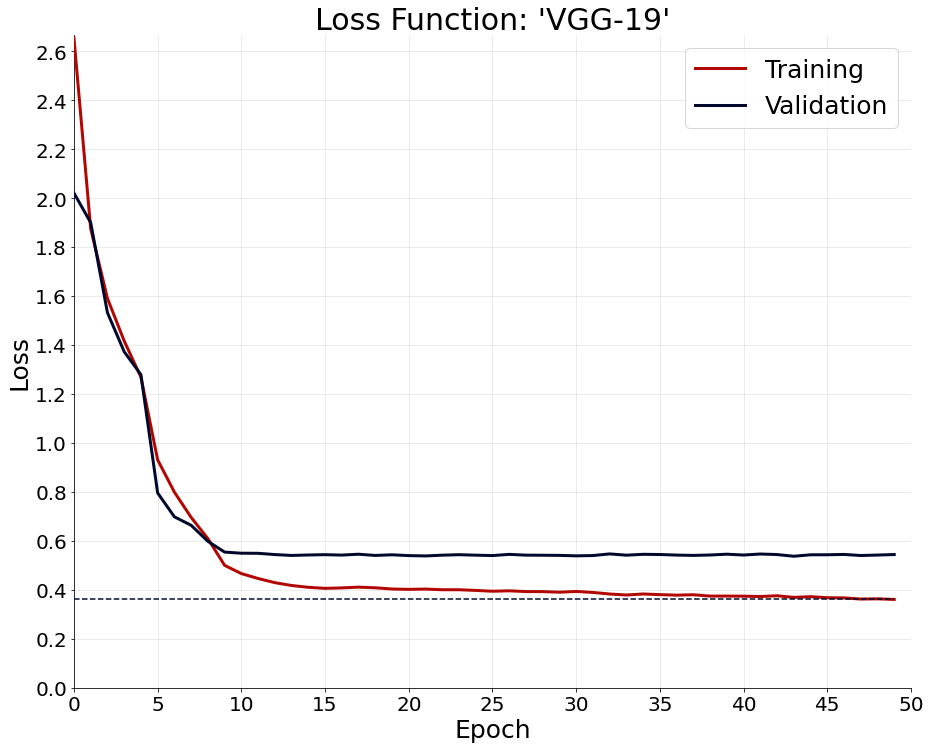

In [132]:
plot_epoch(
    df1=train_loss,
    df2=val_loss,
    df1_label=["loss", "Training"],
    df2_label=["loss", "Validation"],
    figsize=(15,12),
    num_epochs=num_epochs,
    ylabel="Loss",
    ylim=[0, (max_val)+0.01],
    yticks=np.arange(0,(max_val)+0.01,0.2),
    xticks=np.arange(0,num_epochs+1,5),
    legend=True,
    title="Loss Function: 'VGG-19'",
    save_path=f"../plots/{vgg_type}/loss.png"
)

# Accuracy (Top-1)

In [133]:
train_acc1 = train[["epoch","acc1"]].groupby(by="epoch")

train_acc1 = train_acc1.sum() / train_acc1.count()

In [134]:
val_acc1 = val[["epoch","acc1"]].groupby(by="epoch")

val_acc1 = val_acc1.sum() / val_acc1.count()

In [135]:
min_acc1_train = train_acc1.min().item()
max_acc1_train = train_acc1.max().item()

min_acc1_val = val_acc1.min().item()
max_acc1_val = val_acc1.max().item()

min_val = min(min_acc1_train, min_acc1_val)
max_val = max(max_acc1_train, max_acc1_val)

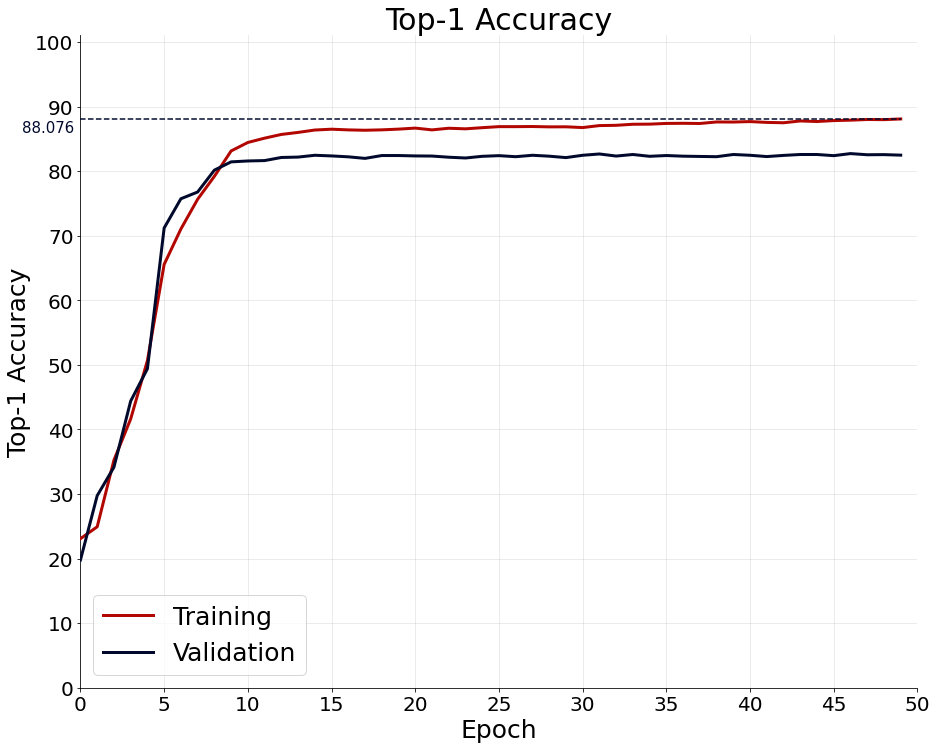

In [137]:
max_val = 100

plot_epoch(
    df1=train_acc1,
    df2=val_acc1,
    df1_label=["acc1", "Training"],
    df2_label=["acc1", "Validation"],
    figsize=(15,12),
    num_epochs=num_epochs,
    ylabel="Top-1 Accuracy",
    ylim=[0, int(max_val)+1],
    yticks=np.arange(0,int(max_val)+.1,10),
    xticks=np.arange(0,num_epochs+1,5),
    legend=True,
    title="Top-1 Accuracy",
    save_path=f"../plots/{vgg_type}/top1.png",
    convergence_mode="max",
    convergence_text={
    "x": -3.5,
    "y": max_val-14,
    }
)

## Accuracy (Top-2)

In [138]:
train_acc2 = train[["epoch","acc2"]].groupby(by="epoch")

train_acc2 = train_acc2.sum() / train_acc2.count()

In [139]:
val_acc2 = val[["epoch","acc2"]].groupby(by="epoch")

val_acc2 = val_acc2.sum() / val_acc2.count()

In [140]:
min_acc2_train = train_acc2.min().item()
max_acc2_train = train_acc2.max().item()

min_acc2_val = val_acc2.min().item()
max_acc2_val = val_acc2.max().item()

min_val = min(min_acc2_train, min_acc2_val)
max_val = max(max_acc2_train, max_acc2_val)

In [141]:
max_acc2_train, max_acc2_val

(95.72146159317212, 92.38782051282051)

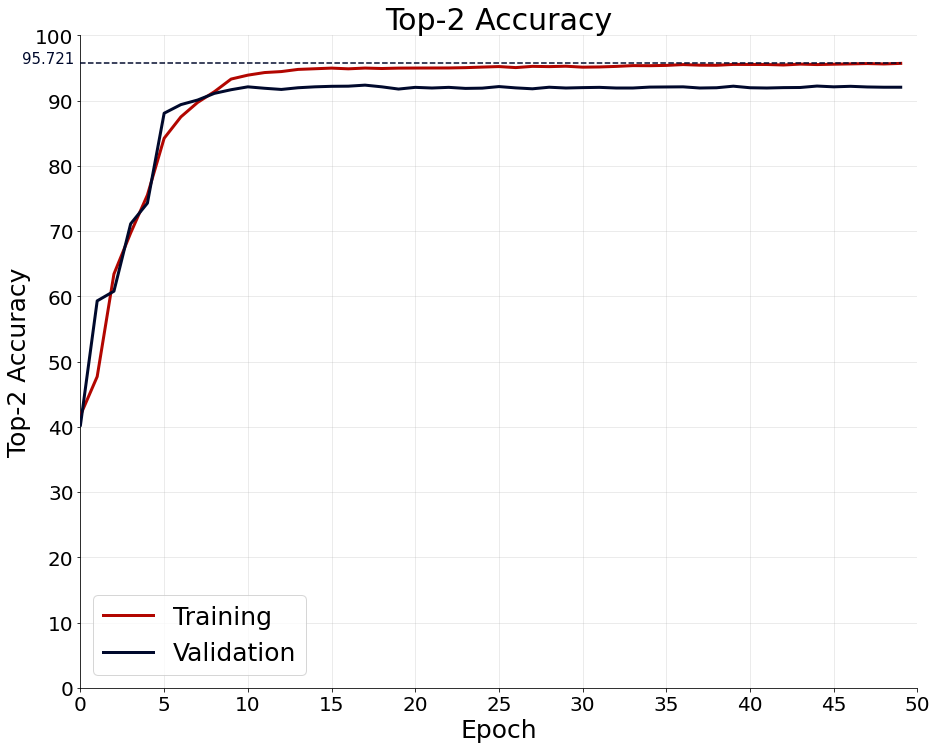

In [143]:
plot_epoch(
    df1=train_acc2,
    df2=val_acc2,
    df1_label=["acc2", "Training"],
    df2_label=["acc2", "Validation"],
    figsize=(15,12),
    num_epochs=num_epochs,
    ylabel="Top-2 Accuracy",
    ylim=[0, int(max_val)+1],
    yticks=np.arange(0,101,10),
    xticks=np.arange(0,num_epochs+1,5),
    legend=True,
    title="Top-2 Accuracy",
    save_path=f"../plots/{vgg_type}/top2.png",
    convergence_mode="max",
    convergence_text={
    "x": -3.5,
    "y": max_val,
    }
)

# Learning Rate

In [120]:
def plot_lr(
    df,
    title,
    save_path
):
    
    df_lr = df[["epoch", "batch_id","lr"]]
    
    iteration_per_epoch = df_lr[["epoch", "batch_id"]].groupby(by="epoch").count()["batch_id"].unique().item()
    
    df_lr = df_lr[["epoch", "batch_id","lr"]]
    df_lr["Iteration"] = df_lr["epoch"] * iteration_per_epoch + df_lr["batch_id"]
    df_lr.rename(columns={"lr": "Learning Rate"}, inplace=True)
    
    min_lr = df_lr["Learning Rate"].min()
    max_lr = df_lr["Learning Rate"].max()

    num_iterations = df_lr["Iteration"].max() - df_lr["Iteration"].min()
    
    num_iterations = int(num_iterations)
    
    ax = plt.gca()

    df_lr.plot(x="Iteration", y="Learning Rate", figsize=(15,10), linewidth=3, ax=ax, zorder=5, color="#00092C")


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xlabel("Iteration", fontsize=25)
    plt.ylabel("Learning Rate (Logarithmic)", fontsize=25)

#     plt.ylim([0, max_lr+ 1e-4])

    plt.xticks(np.arange(0, num_iterations, 5000), fontsize=20)
    plt.yticks(np.arange(0, max_lr+1e-4, 1e-4), fontsize=20)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    plt.grid(alpha=0.3, zorder=0)

    plt.yscale("log")

    ax.get_legend().remove()

    plt.title(title, fontsize=30)

    plt.savefig(save_path)
    plt.show()

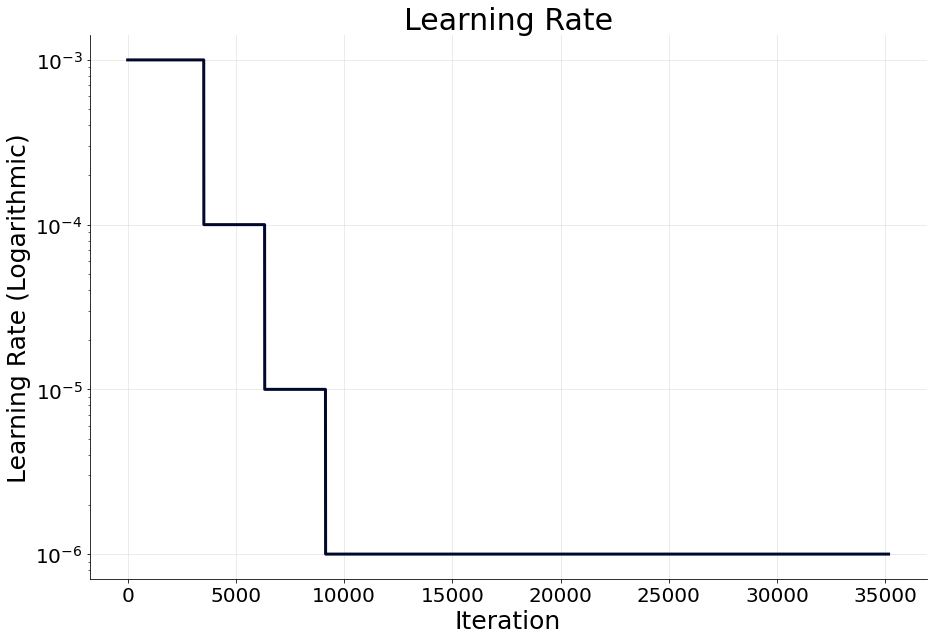

In [121]:
plot_lr(
    train,
    title="Learning Rate",
    save_path=f"../plots/{vgg_type}/lr.png",
)